In [1]:
from py2neo import Graph

In [12]:
# Change the line of code below to use the IP Address, Bolt Port,  and Password of your Sandbox.
# graph = Graph("<Bolt URL>", auth=("neo4j", "<Password>")) 
 
graph = Graph("bolt://100.25.48.12:37028", auth=("neo4j", "auto-development-gunnery"))

# Exploratory Data Analysis

In this notebook you will explore the citation dataset. You should already have installed py2neo, pandas, and matplotlib when setting up our environment, so you will now import them (remember to unset Reset all runtimes before running):

在这本笔记本中，你将探索引文数据集。在设置我们的环境时，您应该已经安装了py2neo、panda和matplotlib，所以现在您将导入它们(请记住在运行前取消设置重置所有运行时):

In [9]:

from py2neo import Graph
import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Next, create a connection to your Neo4j Sandbox, just as you did previously when you set up your environment.   
接下来，创建到Neo4j沙箱的连接，就像之前设置环境时所做的一样。

<div align="left">
    <img src="images/sandbox-citations.png" alt="Citation Sandbox"/>
</div>

Update the cell below to use the IP Address, Bolt Port, and Password, as you did previously.  
像前面一样，更新下面的单元格，使用IP地址、Bolt端口和密码。

In [13]:
# Change the line of code below to use the IP Address, Bolt Port,  and Password of your Sandbox.
# graph = Graph("<Bolt URL>", auth=("neo4j", "<Password>")) 
 
graph = Graph("bolt://100.25.48.12:37028", auth=("neo4j", "auto-development-gunnery"))

## What's in our database?

Run the following query to check how many nodes our database contains:  
运行以下查询来检查我们的数据库包含多少节点:


In [14]:
graph.run("CALL db.schema()").data()

[{'nodes': [(_-3:Venue {constraints: ['CONSTRAINT ON ( venue:Venue ) ASSERT venue.name IS UNIQUE'], indexes: [], name: 'Venue'}),
   (_-1:Article {constraints: ['CONSTRAINT ON ( article:Article ) ASSERT article.index IS UNIQUE'], indexes: [], name: 'Article'}),
   (_-2:Author {constraints: ['CONSTRAINT ON ( author:Author ) ASSERT author.name IS UNIQUE'], indexes: [], name: 'Author'})],
  'relationships': [(Article)-[:VENUE {}]->(Venue),
   (Article)-[:AUTHOR {}]->(Author),
   (Article)-[:CITED {}]->(Article)]}]

If we run that query (CALL db.schema()) in  Neo4j Browser, you see the following visualisation:

<img src="images/data-science-training.png" alt="Graph Data Model"/>


Let's drill down a bit. How many nodes do we have for each of these labels? Run this code:  
我们往下钻一点。每个标签有多少个节点?运行这段代码:

In [21]:
result = {"label": [], "count": []}
for label in graph.run("CALL db.labels()").to_series():
    query = f"MATCH (:`{label}`) RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["label"].append(label)
    result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

,label,count
2,Venue,4
0,Article,51956
1,Author,80299


You can visualize the counts using matplotlib> Run the following code:  
你可以可视化计数使用matplotlib>运行以下代码:

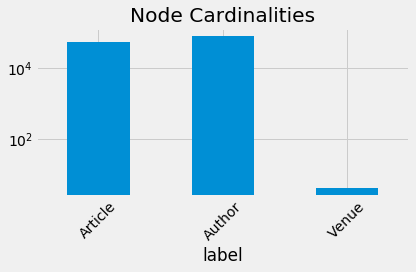

In [25]:
nodes_df.plot(kind="bar", x = "label", y = 'count', legend=None, title= "Node Cardinalities")
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

What types of relationships do we have in our graph? Run this code:  
图中有哪些关系?运行这段代码:

In [28]:
result = {"relType": [], "count": []}
for relationship_type in graph.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["relType"].append(relationship_type)
    result["count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("count")

,relType,count
2,CITED,28706
0,VENUE,51956
1,AUTHOR,140575


You can visualize the counts using matplotlib. Run  the following code:  
您可以使用matplotlib可视化计数。运行以下代码:

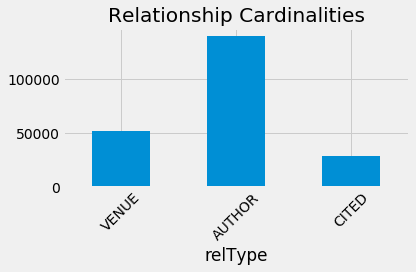

In [30]:
rels_df.plot(kind ="bar", x="relType", y="count", legend=None, title="Relationship Cardinalities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Now let's explore the citation data. The following query finds 25 authors, articles, venues, and also shows the number of articles that article has cited, as well as the number of articles that it's been cited by.
Run this code:  
现在让我们研究引文数据。下面的查询找到了25位作者、文章、地点，还显示了文章被引用的文章数量以及被引用的文章数量。
运行这段代码:


In [32]:
exploratory_query = """
MATCH (author:Author)<-[:AUTHOR]-(article:Article)-[:VENUE]->(venue)
RETURN article.title AS article, author.name AS author, venue.name AS venue, 
       size((article)-[:CITED]->()) AS citationsGiven, size((article)<-[:CITED]-()) AS citationsReceived
ORDER BY rand()
LIMIT 25
"""
graph.run(exploratory_query).to_data_frame()

,article,author,citationsGiven,citationsReceived,venue
0,Enabling coupled scientific simulations on the...,Alan Sussman,0,0,Lecture Notes in Computer Science
1,Exponential laws of computing growth,Peter J. Denning,3,1,Communications of The ACM
2,Distributed data and immersive collaboration,Charles E. Catlett,0,2,Communications of The ACM
3,Bell labs and centralized innovation,Tim Wu,0,0,Communications of The ACM
4,The Role of Contracts in Distributed Development,Giordano Tamburrelli,6,0,international conference on software engineering
5,Parallelization of spectral element methods,Faker Ben Belgacem,0,0,Lecture Notes in Computer Science
6,Symbolic mining of temporal specifications,Mark Gabel,7,7,international conference on software engineering
7,Web service based architecture for workflow ma...,Yun Yang,0,0,Lecture Notes in Computer Science
8,The PatchMatch randomized matching algorithm f...,Connelly Barnes,0,0,Communications of The ACM
9,Multi-physics modeling of hysteresis in vanadi...,Beibei Ren,0,0,advances in computing and communications


Let's look into the citation data more closely. Here is a query that returns the number of citations that each article has, and then creates a distribution of those counts using pandas `describe` function. Run this code:  
让我们更仔细地研究引文数据。下面是一个查询，返回每篇文章的引用数，然后使用panda `describe`函数创建这些引用数的分布。运行这段代码:


In [41]:
query = """
MATCH (a:Article)
RETURN size((a)<-[:CITED]-()) AS citations
"""

citation_df = graph.run(query).to_data_frame()
citation_df.describe([.25, .5, .75, .9, .99])

,citations
count,51956.000
mean,0.553
std,2.418
min,0.000
25%,0.000
50%,0.000
75%,0.000
90%,1.000
99%,8.000
max,211.000


Most articles are being cited very few times. 99% of articles have 8 citations or less. We do, however, have one article that's been cited more than 200 times. We'll use a log scale histogram to visualise the data. Run this code:  
大多数文章被引用的次数很少。99%的文章被引用次数不超过8次。然而，我们确实有一篇文章被引用了200多次。我们将使用对数尺度直方图来可视化数据。运行这段代码:

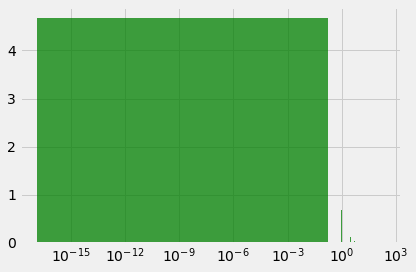

In [45]:
fig1, ax1 = plt.subplots()
ax1.hist(pd.Series(citation_df['citations'].dropna()), 1250, density=True, facecolor='g', alpha=0.75)
ax1.set_xscale("log")
plt.tight_layout()
plt.show()

## Exercise instructions

1. Create a similar query showing the articles that cite the most other papers? Note that you'll only need to do a slight tweak of the Cypher query to do this. 
2. What about a distribution of the number of articles published by authors?  


1. 创建一个类似的查询，显示引用最多其他论文的文章?注意，您只需要稍微调整Cypher查询就可以做到这一点。
2. 那么作者发表的文章数量的分布呢?

Keep the results of this exercise handy as they may be useful for the quiz at the end of this module. 
把这个练习的结果放在手边，因为它们可能对本模块最后的测验有用。

In [51]:
query = """
MATCH (a:Article)
RETURN  size((a)-[:CITED]->()) AS citations , a.title AS article
ORDER BY citations DESC limit 10
"""
graph.run(query).to_data_frame()

,article,citations
0,Translator writing systems,51
1,Curriculum 68: Recommendations for academic pr...,50
2,Towards novel neuroscience-inspired computing,35
3,Research Directions in Requirements Engineering,34
4,Information science in a Ph.D. computer scienc...,25
5,The role of programming in a Ph.D. computer sc...,23
6,Towards biomimetic neural learning for intelli...,20
7,Source Code Analysis: A Road Map,20
8,Software testing: a research travelogue (2000–...,20
9,Trust management survey,19


In [52]:
query = """
MATCH (author:Author)
RETURN size((author)<-[:AUTHOR]-(:Article)) AS publish, author.name AS author
ORDER BY publish DESC LIMIT 5
"""
graph.run(query).to_data_frame()

,author,publish
0,Peter G. Neumann,89
1,Peter J. Denning,80
2,Moshe Y. Vardi,72
3,Pamela Samuelson,71
4,Bart Preneel,65
